# Prompt-Based Editing for Text Style Transfer

### Notebook Overview
This notebook implements **prompt-based editing** for text style transfer on the Yelp dataset.  
We:
- Prepare data and sample inputs
- Define text editing and scoring models
- Run hill-climbing style transfer
- Evaluate outputs using sentiment, perplexity, and semantic similarity

In [1]:
!pip install nltk numpy python-dateutil python-rake transformers torch sentencepiece

In [2]:
import nltk
import math
import os
import logging
import torch
import torch.nn as nn
import sys
import numpy as np
import RAKE
import datetime
from dateutil import tz
from tqdm import tqdm
from transformers import logging as hf_logging
hf_logging.set_verbosity_error()
from transformers import GPT2LMHeadModel, GPT2Tokenizer, RobertaTokenizer, RobertaForMaskedLM, RobertaForSequenceClassification, \
AutoModelForCausalLM, AutoTokenizer, AutoModelForSequenceClassification
from torch.nn import CrossEntropyLoss
import random
import pandas as pd
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer, util

nltk.download('averaged_perceptron_tagger_eng')
nltk.download('punkt')

[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

stopwords = '#$%&()*+--)–/:;<=>@[\\]^_`{|}~—•… ™—' + '0123456789'

DATASET_DICT = {
    'yelp': {
        'from': ['positive', 'negative'],
        'from_to': {'positive': 'negative', 'negative': 'positive'},
        'examples': [
            ('negative', 'this place is awful!'),
            ('positive', 'this place is amazing!', 'negative'),
            ('negative', 'i hated their black tea and hated hot chocolate selections!'),
            ('positive', 'i loved their black tea and loved hot chocolate selections!'),
        ],
    },
}

def write_sentence(dataset, delim_left, delim_right, orig_text, rewritten_text=None):
    style_word = 'sentiment' if dataset == 'yelp' else 'style'
    sentence = f'The {style_word} of the text {delim_left}{orig_text}{delim_right} is'
    if rewritten_text is not None:
        sentence = f'{sentence} {rewritten_text}'
    return sentence

FS_EOS_TOKEN = '\n###\n'

def create_exemplars(dataset, num_examples, delim_left, delim_right):
    prefix = ''
    examples = DATASET_DICT[dataset]['examples'][:num_examples]
    for example in examples:
        orig_style, orig_text = example[0], example[1]
        add_text = write_sentence(dataset, delim_left, delim_right, orig_text, orig_style)
        prefix += f'{add_text}{FS_EOS_TOKEN}'
    return prefix

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

def softmax(x):
    x = x - torch.max(x)
    exp_x = torch.exp(x)
    softmax_x = exp_x / torch.sum(exp_x)
    return softmax_x

def pytorch_cos_sim(a, b):
    if not isinstance(a, torch.Tensor):
        a = torch.tensor(a)
    if not isinstance(b, torch.Tensor):
        b = torch.tensor(b)
    if len(a.shape) == 1:
        a = a.unsqueeze(0)
    if len(b.shape) == 1:
        b = b.unsqueeze(0)
    a_norm = torch.nn.functional.normalize(a, p=2, dim=1)
    b_norm = torch.nn.functional.normalize(b, p=2, dim=1)
    return torch.mm(a_norm, b_norm.transpose(0, 1))

In [4]:
def predict_next_word(model, tokenizer, input_text, direction, dst, setting):
    tokens_tensor = {k: v.to(device) for k, v in tokenizer(input_text, padding=True, return_tensors="pt").items()}
    model.eval()
    with torch.no_grad():
        outputs = model(**tokens_tensor)
        predictions = outputs.logits
    probs = predictions[:, -1, :]

    pos_id = tokenizer.encode(' positive')[0] if ' positive' in tokenizer.get_vocab() else tokenizer.encode('positive')[0]
    neg_id = tokenizer.encode(' negative')[0] if ' negative' in tokenizer.get_vocab() else tokenizer.encode('negative')[0]

    pos_logits = probs[:, pos_id]
    neg_logits = probs[:, neg_id]

    emo_logits = torch.stack((neg_logits, pos_logits), dim=1)
    softmax_emo_logits = torch.softmax(emo_logits, dim=1)

    neg_prob = softmax_emo_logits[:, 0]
    pos_prob = softmax_emo_logits[:, 1]

    if direction == '0-1':
        output_prob = pos_prob / (neg_prob + 1e-8)
    else:
        output_prob = neg_prob / (pos_prob + 1e-8)

    if setting == 'zero-shot':
        thres_neg = 0.6 if dst == 'yelp' else 0.7
        thres_pos = 0.9
    else:
        thres_neg = 0.6
        thres_pos = 0.9

    argmax_labels = torch.argmax(softmax_emo_logits, dim=1)
    labels = []
    for idx in range(len(softmax_emo_logits)):
        if argmax_labels[idx] == 0 and neg_prob[idx] >= thres_neg:
            labels.append(0)
        elif argmax_labels[idx] == 1 and pos_prob[idx] >= thres_pos:
            labels.append(1)
        else:
            labels.append(2)

    return output_prob, labels

### Model Arguments

In [9]:
class Args:
    def __init__(self):
        self.output_dir = 'yelp/'
        self.max_len = 32
        self.seed = 42
        self.class_name = 'EleutherAI/gpt-neo-2.7B'
        self.topk = 15
        self.direction = '0-1'
        self.fluency_weight = 4
        self.sem_weight = 4
        self.style_weight = 12
        self.max_steps = 6
        self.dst = 'yelp'
        self.setting = 'zero-shot'
        self.bsz = 1
        self.keyword_pos = True
        self.early_stop = True

In [10]:
class RobertaEditor(nn.Module):
    def __init__(self, opt):
        super(RobertaEditor, self).__init__()
        self.opt = opt
        self.topk = opt.topk
        self.model_dir = 'roberta-large'
        self.model = RobertaForMaskedLM.from_pretrained(self.model_dir, return_dict=True).to(device)
        self.tokenizer = RobertaTokenizer.from_pretrained(self.model_dir)
        self.ops_map = [self.replace, self.insert, self.delete]
        self.max_len = opt.max_len
        self.Rake = RAKE.Rake(RAKE.SmartStopList())

    def edit(self, inputs, ops, positions, bsz, max_len=None):
        masked_inputs = []
        for inp, op, position in zip(inputs, ops, positions):
            try:
                masked_input = self.ops_map[op](inp, position)
                masked_inputs.append(masked_input)
            except IndexError:
                continue
        if not masked_inputs:
            return []
        array_masked_inputs = np.array(masked_inputs)

        if ops[0] < 2:
            index = [idx for idx, masked_input in enumerate(masked_inputs) if '<mask>' in masked_input]
            if not index:
                return [masked_inputs]
            mask_inputs = array_masked_inputs[index]
            mask_outputs = self.generate(mask_inputs.tolist(), max_len or self.max_len)
            output_lists = mask_outputs
        else:
            output_lists = [masked_inputs]

        return output_lists

    def generate(self, input_texts, max_len):
        total_sent_list = []
        rbt_sent_list = self.plm_token(input_texts, max_len)

        for idx, rbt_sent in enumerate(rbt_sent_list):
            try:
                ids = torch.tensor([self.tokenizer.convert_tokens_to_ids(rbt_sent)]).to(device)
                mask_token_index = torch.where(ids == self.tokenizer.mask_token_id)[1]
                if mask_token_index.numel() == 0:
                    total_sent_list.append([])
                    continue
                token_logits = self.model(ids).logits
                masked_token_logits = token_logits[0, mask_token_index, :]

                top_tokens = torch.topk(masked_token_logits, self.topk, dim=1).indices[0]
                mask_words_list = list(set(self.tokenizer.decode([token.item()]).lower().strip() for token in top_tokens))

                mask_words = [token for token in mask_words_list if len(set(token.split()) & set(stopwords)) == 0 and token not in 'bcdefghjklmnopqrstvwxyz']

                sent_list = []
                for mask_word in mask_words:
                    split_text = input_texts[idx].split()
                    mask_word_index = mask_token_index - 1
                    if 0 < mask_word_index.item() < len(split_text) - 1 and (split_text[mask_word_index.item() - 1] == mask_word or split_text[mask_word_index.item() + 1] == mask_word):
                        continue
                    elif mask_word_index.item() == 0 and len(split_text) > 1 and split_text[mask_word_index.item() + 1] == mask_word:
                        continue
                    elif mask_word_index.item() == len(split_text) - 1 and len(split_text) > 1 and split_text[mask_word_index.item() - 1] == mask_word:
                        continue
                    else:
                        cand_sent = input_texts[idx].replace("<mask>", mask_word.strip()).lower()
                        cand_sent = ' '.join(cand_sent.split()[:max_len])
                        sent_list.append(cand_sent)

                total_sent_list.append(sent_list)
            except Exception as e:
                print(f"Generate error for input {input_texts[idx]}: {e}")
                total_sent_list.append([])
                continue

        return total_sent_list

    def insert(self, input_text, mask_idx):
        try:
            input_texts_with_mask_list = input_text.split()[:mask_idx] + ["<mask>"] + input_text.split()[mask_idx:]
            return " ".join(input_texts_with_mask_list)
        except:
            return input_text

    def replace(self, input_text, mask_idx):
        try:
            input_texts_with_mask_list = input_text.split()[:mask_idx] + ["<mask>"] + input_text.split()[mask_idx + 1:]
            return " ".join(input_texts_with_mask_list)
        except:
            return input_text

    def delete(self, input_text, mask_idx):
        try:
            input_texts_with_mask_list = input_text.split()[:mask_idx] + input_text.split()[mask_idx + 1:]
            return " ".join(input_texts_with_mask_list)
        except:
            return input_text

    def plm_token(self, lines, max_len):
        rbt_lines = []
        for line in lines:
            plm_line = []
            line = line.split()
            for idx, token in enumerate(line):
                if idx == 0:
                    plm_line.append(token)
                else:
                    if token in ["'s", "'d", "'m", "'re", "'ve", "'ll", "n't", "<mask>"]:
                        plm_line.append(token)
                    else:
                        token = 'Ġ' + token
                        plm_line.append(token)
            plm_line = plm_line[:self.max_len]
            rbt_line = ['<s>'] + plm_line + ['</s>']
            rbt_lines.append(rbt_line)
        return rbt_lines

    def state_vec(self, inputs):
        sta_vec_list = []
        pos_list = []
        for line in inputs:
            line = ' '.join(line.split()[:self.max_len])
            sta_vec = list(np.zeros([self.max_len]))
            try:
                keyword = self.Rake.run(line)
                pos_tags = nltk.pos_tag(line.split())
            except LookupError as e:
                print(f"NLTK error in state_vec: {e}. Using default POS.")
                keyword = []
                pos_tags = [(w, 'NN') for w in line.split()]
            pos = [x[1] for x in pos_tags]
            pos_list.append(pos)

            if keyword:
                keyword = list(list(zip(*keyword))[0])
                keyword_new = []
                linewords = line.split()
                for i in range(len(linewords)):
                    for item in keyword:
                        length = len(item.split())
                        if ' '.join(linewords[i:i + length]) == item:
                            keyword_new.extend([i + k for k in range(length)])
                for ind in keyword_new:
                    if ind <= self.max_len - 2:
                        sta_vec[ind] = 1

            if self.opt.keyword_pos:
                sta_vec_list.append(self.keyword_pos2sta_vec(sta_vec, pos))
            else:
                if sum(sta_vec) == 0:
                    sta_vec[0] = 1
                sta_vec_list.append(sta_vec)

        return sta_vec_list, pos_list

    def keyword_pos2sta_vec(self, keyword, pos):
        key_ind = []
        pos = pos[:self.max_len]
        for i in range(len(pos)):
            if keyword[i] == 1:
                key_ind.append(i)
            elif pos[i] in ['JJS', 'JJR', 'JJ', 'RBR', 'RBS', 'RB', 'VBZ', 'VBP', 'VBN', 'VBG', 'VBD', 'VB'] and keyword[i] == 0:
                key_ind.append(i)
        sta_vec = [1 if i in key_ind else 0 for i in range(len(keyword))]
        if sum(sta_vec) == 0:
            sta_vec[0] = 1
        return sta_vec

    def mean_pooling(self, model_output, attention_mask):
        token_embeddings = model_output[0]
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
        return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)

    def get_contextual_word_embeddings(self, input_texts):
        if not isinstance(input_texts, list):
            input_texts = [input_texts]
        input_texts = [str(text) for text in input_texts if text and isinstance(text, str)]
        if not input_texts:
            print("Warning: Empty or invalid input_texts in get_contextual_word_embeddings")
            return torch.zeros(1, self.max_len, 1024).to(device), torch.zeros(1, 1024).to(device)

        try:
            inputs = {k: v.to(device) for k, v in self.tokenizer(input_texts, padding=True, return_tensors="pt", truncation=True, max_length=self.max_len).items()}
            outputs = self.model(**inputs, output_hidden_states=True)
            sentence_embeddings = self.mean_pooling(outputs, inputs['attention_mask'])
            hidden_states = outputs.hidden_states[-1][:, 1:self.max_len + 1, :].to(device)
            return hidden_states, sentence_embeddings
        except Exception as e:
            print(f"Tokenization error in get_contextual_word_embeddings: {e}")
            return torch.zeros(1, self.max_len, 1024).to(device), torch.zeros(1, 1024).to(device)

In [11]:
class SteepHC(nn.Module):
    def __init__(self, opt, editor):
        super(SteepHC, self).__init__()
        self.opt = opt
        self.editor = editor
        self.flu_w = opt.fluency_weight
        self.sem_w = opt.sem_weight
        self.style_w = opt.style_weight
        self.stride = 1024
        self.dst = self.opt.dst

        self.plm = AutoModelForCausalLM.from_pretrained(
          self.opt.class_name,
          torch_dtype=torch.float16,
          device_map="auto"
        )
        self.plm.eval()

        self.tokenizer = AutoTokenizer.from_pretrained(self.opt.class_name)
        self.tokenizer.pad_token = self.tokenizer.eos_token

        self.max_len = self.opt.max_len
        self.model = GPT2LMHeadModel.from_pretrained('gpt2').to(device)
        self.ppl_max_len = self.model.config.n_positions

    def style_scorer(self, ref_news):
        if self.opt.setting == 'zero-shot':
            num_es = 0
            delim_left1, delim_right1 = "", ""
        else:
            num_es = 4
            delim_left1, delim_right1 = "{", "}"

        prefix = create_exemplars(self.dst, num_es, delim_left1, delim_right1)
        prompts = [write_sentence(self.dst, "{", "}", text) for text in ref_news if text]
        input_candidate_text = [prefix + prompt for prompt in prompts]

        if not input_candidate_text:
            return torch.tensor([0.0]).to(device), [2]

        style_probs, style_labels = predict_next_word(self.plm, self.tokenizer, input_candidate_text, self.opt.direction, self.dst, self.opt.setting)
        prob_new_probs = torch.pow(style_probs, self.style_w)

        return prob_new_probs, style_labels

    def fluency_scorer(self, ref_news):
        ref_news = [text for text in ref_news if text]
        if not ref_news:
            return torch.tensor([1.0]).to(device)

        encodings = self.tokenizer(ref_news, return_tensors="pt", padding=True, max_length=self.max_len, truncation=True).to(device)
        input_ids = encodings.input_ids
        begin_loc = max(self.stride - self.ppl_max_len, 0)
        end_loc = min(self.stride, input_ids.size(1))
        trg_len = end_loc
        input_ids = input_ids[:, begin_loc:end_loc].to(device)
        target_ids = input_ids.clone()
        target_ids[:, :-trg_len] = -100

        with torch.no_grad():
            outputs = self.model(input_ids, labels=target_ids)
            lm_logits = outputs.logits
            shift_logits = lm_logits[..., :-1, :].contiguous()
            shift_labels = target_ids[..., 1:].contiguous()
            loss_fct = CrossEntropyLoss(ignore_index=-100, reduction='none')
            loss = loss_fct(shift_logits.view(-1, lm_logits.size(-1)), shift_labels.view(-1))
            ppl = torch.exp(loss.reshape(-1, input_ids.shape[1] - 1).mean(dim=1))

        return 1 / ppl.pow(self.flu_w)

    def keyword_sim(self, ref_new_embeds, ref_old_embeds, state_vec=None):
        e = 1e-5
        repeat_num = ref_new_embeds.size(0)
        emb1 = ref_new_embeds.permute(0, 2, 1)
        emb2 = ref_old_embeds.repeat(repeat_num, 1, 1)
        emb_mat = torch.bmm(emb2, emb1)
        state_vec = torch.tensor(state_vec, dtype=torch.bool, device=device)
        weight2 = state_vec.repeat(repeat_num, 1)[:, :emb2.shape[1]]
        norm2 = 1 / (torch.norm(emb2, p=2, dim=2) + e)
        norm1 = 1 / (torch.norm(emb1, p=2, dim=1) + e)
        diag_norm2 = torch.diag_embed(norm2)
        diag_norm1 = torch.diag_embed(norm1)
        sim_mat = torch.bmm(torch.bmm(diag_norm2, emb_mat), diag_norm1)
        sim_vec, _ = torch.max(sim_mat, dim=2)
        try:
            kw_similarity, _ = torch.min(sim_vec[weight2].reshape(repeat_num, -1), dim=1)
        except:
            weight2[:, 0] = True
            kw_similarity, _ = torch.min(sim_vec[weight2].reshape(repeat_num, -1), dim=1)
        return kw_similarity

    def semantic_scorer(self, ref_news, ref_olds, state_vec=None):
        ref_new_embeds, mean_new_embeds = self.editor.get_contextual_word_embeddings(ref_news)
        ref_old_embeds, mean_old_embeds = self.editor.get_contextual_word_embeddings(ref_olds)
        kw_sim = self.keyword_sim(ref_new_embeds, ref_old_embeds, state_vec)
        sent_sim = pytorch_cos_sim(mean_new_embeds, mean_old_embeds)
        similarity = kw_sim.pow(self.sem_w) * sent_sim.pow(self.sem_w).squeeze()
        return similarity

    def scorer(self, input_news, ref_oris, state_vec=None):
        input_news = [text for text in input_news if text]
        if not input_news:
            return torch.tensor([0.0]).to(device), [2]
        fluency_scores = self.fluency_scorer(input_news)
        style_scores, style_labels = self.style_scorer(input_news)
        sim_scores = self.semantic_scorer(input_news, ref_oris, state_vec).squeeze()
        total_scores = fluency_scores * sim_scores * style_scores
        return total_scores.squeeze(), style_labels

    def acceptance_prob(self, input_news, input_olds, ref_oris, state_vec):
        input_news = [text for text in input_news if text]
        if not input_news:
            return 0, torch.tensor([0.0]).to(device), torch.tensor([0.0]).to(device), [2], [0]
        ref_old_score, _ = self.scorer(input_olds, ref_oris, state_vec)
        ref_new_scores, new_style_labels = self.scorer(input_news, ref_oris, state_vec)
        ref_new_score_index = torch.argmax(ref_new_scores)
        ref_new_score = torch.max(ref_new_scores)
        accept = [1 if ref_new_score - ref_old_score > 0 else 0]
        return ref_new_score_index, ref_old_score, ref_new_score, new_style_labels, accept

### Load Yelp Sentiment Dataset

In [12]:
file_path = '/content/data/yelp/test.0'

with open(file_path, 'r') as f:
    sample_negative = [line.strip() for line in f.readlines()]

print("Loaded", len(sample_negative), "lines from", file_path)

Loaded 500 lines from /content/data/yelp/test.0


### Main Function

In [ ]:
def main():
    args = Args()
    set_seed(args.seed)
    editor = RobertaEditor(args).to(device)
    sahc = SteepHC(args, editor).to(device)
    of_dir = 'results/' + args.output_dir
    os.makedirs(of_dir, exist_ok=True)

    if args.direction == '0-1':
        postfix = '0'
    else:
        postfix = '1'

    filename = f'/content/data/{args.dst}/test.{postfix}'
    try:
        with open(filename, 'r', encoding='utf8') as f:
            data = f.readlines()
    except FileNotFoundError:
        print(f"Error: {filename} not found.")
        return None

    bsz = args.bsz
    max_len = args.max_len
    dst = args.dst
    num_batches = math.ceil(len(data) / bsz)
    timestamp = datetime.datetime.now().astimezone(tz.gettz()).strftime('%Y-%m-%d_%H:%M:%S')
    output_file = f'{timestamp}_{dst}_seed={args.seed}_{args.style_weight}_{args.direction}.txt'
    log_txt_path = os.path.join(of_dir, output_file.replace('.txt', '.log'))
    logging.basicConfig(filename=log_txt_path, level=logging.INFO, format='')

    word_pairs = {"ca n't": "can not", "wo n't": "will not"}
    logging.info(str(args.__dict__))

    def print_es():
        print("Early Stopping!")
        logging.info("Early Stopping!")

    output_path = os.path.join(of_dir, output_file)
    with open(output_path, 'w', encoding='utf8') as f:
        for i in range(num_batches):
            batch_data = data[bsz * i:bsz * (i + 1)]
            ref_oris = []
            for d in batch_data:
                d = d.strip().lower()
                for k, v in word_pairs.items():
                    d = d.replace(k, v)
                ref_oris.append(d)

            ref_olds = ref_oris.copy()
            state_vec, _ = editor.state_vec(ref_olds)

            break_flag = False
            max_score = 0
            step_max_score_list = [0]
            seq_len = [len(line.split()) for line in ref_olds]
            max_seq_len = max(seq_len, default=1)

            select_sent = ref_olds[0]

            for step in range(args.max_steps):
                ref_news = []
                for positions in range(max_seq_len + 1):
                    for ops in [0, 1, 2]:
                        try:
                            edited = editor.edit(ref_olds, [ops] * bsz, [positions] * bsz, bsz, max_len)
                            if edited and any(e for e in edited if e):
                                ref_news.extend([e for sublist in edited for e in (sublist if isinstance(sublist, list) else [sublist]) if e])
                        except Exception as e:
                            print(f"Edit error at step {step}, pos {positions}, op {ops}: {e}")
                            continue

                if not ref_news:
                    print("No valid candidates generated. Skipping step.")
                    break

                for ref_new_batch_data in ref_news:
                    try:
                        if isinstance(ref_new_batch_data, list):
                            ref_new_batch_data = ref_new_batch_data[0] if ref_new_batch_data else ref_olds[0]
                        index, ref_old_score, ref_new_score, new_style_labels, _ = sahc.acceptance_prob(
                            [ref_new_batch_data], ref_olds, ref_oris, state_vec)
                        ref_hat = ref_new_batch_data
                        new_style_label = new_style_labels[index]

                        if ref_new_score > max_score and ref_new_score > ref_old_score:
                            max_score = ref_new_score
                            select_sent = ref_hat

                        if args.early_stop:
                            if (args.direction == '0-1' and new_style_label == 1) or (args.direction == '1-0' and new_style_label == 0):
                                select_sent = ref_hat
                                print_es()
                                break_flag = True
                                break
                    except Exception as e:
                        print(f"Scoring error for candidate {ref_new_batch_data}: {e}")
                        continue

                if break_flag:
                    break

                if max_score > step_max_score_list[step]:
                    print("hill climbing!")
                    logging.info("hill climbing!")
                    ref_olds = [select_sent]
                    step_max_score_list.append(max_score.item())
                else:
                    print("don't climb, stop!")
                    logging.info("don't climb, stop!")
                    break_flag = True

                if break_flag:
                    break

            logging.info(f'climb {step + 1} steps, the selected sentence is: {select_sent}')
            print(f'climb {step + 1} steps, the selected sentence is: {select_sent}')

            f.write(select_sent + '\n')
            f.flush()

    print(f"Outputs saved to {output_path}")
    return output_path

output_path = main()

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/10.7G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/200 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/90.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

hill climbing!
hill climbing!
hill climbing!
hill climbing!
don't climb, stop!
climb 5 steps, the selected sentence is: even since joes has changed hands and it 's just gotten better and worse !
hill climbing!
hill climbing!
hill climbing!
hill climbing!
don't climb, stop!
climb 5 steps, the selected sentence is: , and there is definitely still enough dance room in that part of the venue .
hill climbing!
hill climbing!
hill climbing!
hill climbing!
hill climbing!
hill climbing!
climb 6 steps, the selected sentence is: so they may be less watered down and .
hill climbing!
hill climbing!
hill climbing!
don't climb, stop!
climb 4 steps, the selected sentence is: after she said she we i 'd be back and disappeared for a few minutes .
hill climbing!
hill climbing!
hill climbing!
don't climb, stop!
climb 4 steps, the selected sentence is: i can not believe how amazingly awesome this site is .
hill climbing!
hill climbing!
hill climbing!
hill climbing!
hill climbing!
hill climbing!
climb 6 ste

### Classification & Semantic Similarity

In [ ]:
cls_name = 'VictorSanh/roberta-base-finetuned-yelp-polarity'
cls_tok = AutoTokenizer.from_pretrained(cls_name)
cls_model = AutoModelForSequenceClassification.from_pretrained(cls_name).to(device)
cls_model.eval()

def classify_texts(texts):
    toks = cls_tok(texts, truncation=True, padding=True, return_tensors='pt').to(device)
    with torch.no_grad():
        logits = cls_model(**toks).logits
        probs = torch.nn.functional.softmax(logits, dim=-1).cpu().numpy()
    return probs[:, 1]

sem_model = SentenceTransformer("all-MiniLM-L6-v2")

def semantic_similarity(a, b):
    embeddings = sem_model.encode([a, b], convert_to_tensor=True)
    return util.cos_sim(embeddings[0], embeddings[1]).item()

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/559 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/772 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/501M [00:00<?, ?B/s]

### Perplexity

In [ ]:
ppl_tokenizer = AutoTokenizer.from_pretrained("EleutherAI/gpt-neo-1.3B")
ppl_model = AutoModelForCausalLM.from_pretrained("EleutherAI/gpt-neo-1.3B").to(device)
ppl_model.eval()

def perplexity(text):
    enc = ppl_tokenizer(text, return_tensors='pt', truncation=True, max_length=128).to(device)
    with torch.no_grad():
        out = ppl_model(**enc, labels=enc.input_ids)
    return math.exp(out.loss.item())

tokenizer_config.json:   0%|          | 0.00/200 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/90.0 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/10.7G [00:00<?, ?B/s]

### Results Comparison and Plotting

In [ ]:
def compare_results(orig_file, gen_file):
    with open(orig_file, 'r', encoding='utf8') as f:
        orig_sents = [l.strip() for l in f.readlines() if l.strip()]
    with open(gen_file, 'r', encoding='utf8') as f:
        gen_sents = [l.strip() for l in f.readlines() if l.strip()]

    results = []
    for o, g in tqdm(zip(orig_sents, gen_sents), total=min(len(orig_sents), len(gen_sents)), desc="Evaluating"):
        o_sentiment = classify_texts([o])[0]
        g_sentiment = classify_texts([g])[0]
        sem_sim = semantic_similarity(o, g)

        results.append({
            "original": o,
            "rewritten": g,
            "baseline_sentiment": o_sentiment,
            "steered_sentiment": g_sentiment,
            "baseline_perplexity": perplexity(o),
            "steered_perplexity": perplexity(g),
            "semantic_similarity": sem_sim
        })

    return pd.DataFrame(results)


In [ ]:
def plot_results(df, title_prefix):
    # Sentiment
    plt.figure(figsize=(12,5))
    plt.plot(df.index, df['baseline_sentiment'], label='Original Sentiment', marker='o')
    plt.plot(df.index, df['steered_sentiment'], label='Rewritten Sentiment', marker='o')
    plt.title(f"{title_prefix}: Sentiment Shift")
    plt.xlabel("Sentence Index")
    plt.ylabel("Positive Sentiment Probability")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Perplexity
    plt.figure(figsize=(12,5))
    plt.plot(df.index, df['baseline_perplexity'], label='Original PPL', marker='o')
    plt.plot(df.index, df['steered_perplexity'], label='Rewritten PPL', marker='o')
    plt.title(f"{title_prefix}: Perplexity")
    plt.xlabel("Sentence Index")
    plt.ylabel("Perplexity")
    plt.legend()
    plt.grid(True)
    plt.show()


Evaluating: 100%|██████████| 39/39 [00:06<00:00,  5.69it/s]


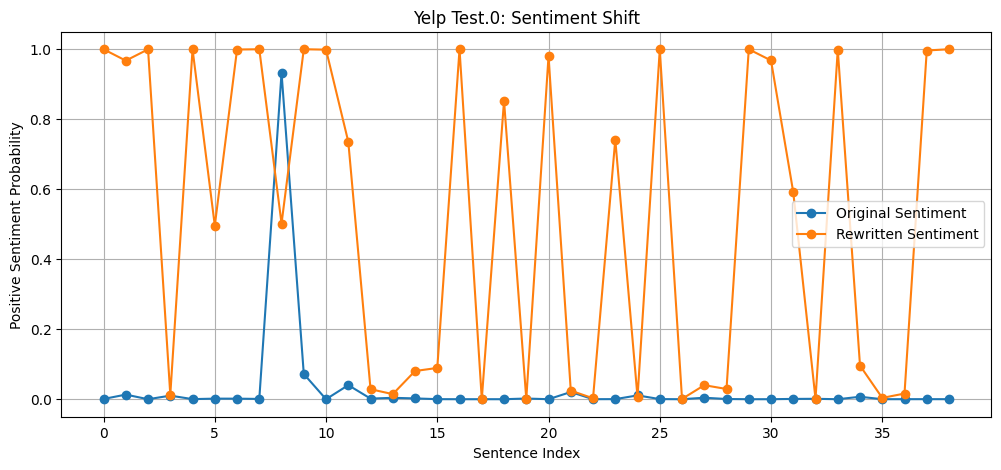

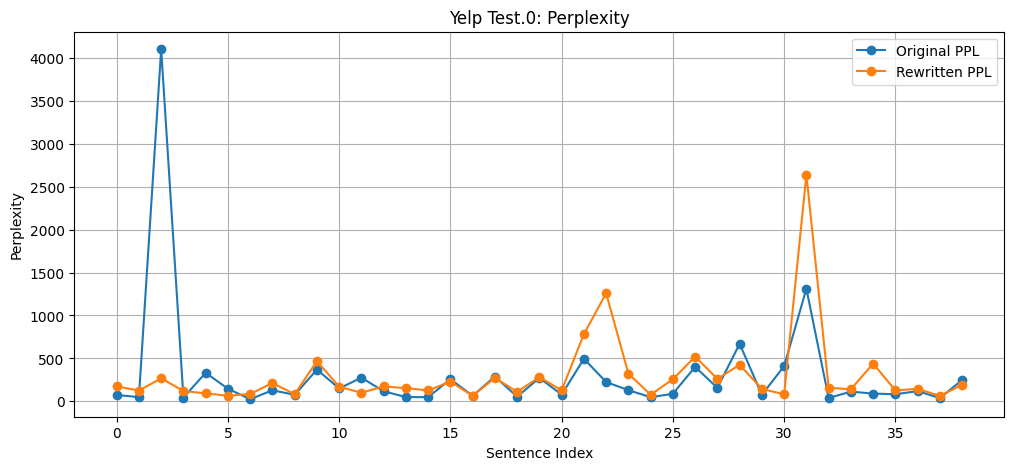

In [ ]:
orig_file = "/content/data/yelp/test.0"
gen_file = output_path
df = compare_results(orig_file, gen_file)

plot_results(df, "Yelp Test.0")

In [ ]:
print("Average Baseline Sentiment:", df['baseline_sentiment'].mean())
print("Average Steered Sentiment:", df['steered_sentiment'].mean())
print("Average Baseline Perplexity:", df['baseline_perplexity'].mean())
print("Average Steered Perplexity:", df['steered_perplexity'].mean())
print("Average Semantic Similarity:", df['semantic_similarity'].mean())

Average Baseline Sentiment: 0.02907745
Average Steered Sentiment: 0.5198086
Average Baseline Perplexity: 300.9295600232479
Average Steered Perplexity: 295.7710737526562
Average Semantic Similarity: 0.6850492763213623
